# Recitation 6 -- Numerical Methods

This recitation is designed to get you re-acquainted with Python ahead of our next lab, and also to introduce you to a few basic schemes one might use in solving a differential equation (like, say, the stellar structure equations...). Derivatives show up all the time in astronomy and physics, and so it is important to have some way to evaluate differential equations with a computer. Next week in lab we'll be using output from a fancy stellar evolution code called [MESA](http://mesa.sourceforge.net/) that will do this much better, but it's good to have some kind of basis before jumping into that.

Recall from class the stellar structure equations:

$\frac{\mathrm{d}M}{\mathrm{d}r} = 4\pi r^2 \rho $

$ \frac{\mathrm{d}P}{\mathrm{d}r} = \frac{-G M \rho}{r^2}$

where $M$ is the mass contained within a spherical shell of radius $r$,

$P$ is the pressure at radius r, and 

the mass density $\rho$ is a function of pressure given by $\rho(P) = (\frac{P}{K})^{\frac{n}{n+1}}$, where $K$ is some constant and $n$ is the *polytropic index*.

This polytropic index business comes from assuming a relationship between the pressure and the density (which should make some intuitive sense) of the form $P = K\rho^{1+\frac{1}{n}}$. Don't worry about it too much for now, it's just a simplification for our modelling scheme that helps us approximate a star. I think Chandrasekhar first came up with the idea, and while new models are fancier (e.g. MESA uses the equation of state such that $P(\rho)$ is not a polytrope but rather also a function of temperature) this is still a valid method of thinking about things. 

For more on polytropes and some horrible math, see [here](https://www.astro.princeton.edu/~gk/A403/polytrop.pdf). Aren't you glad we can use computers to integrate things these days?

Below I've lightly adapted a simple code I found on [GitHub](https://github.com/Yurlungur/stellar-structure) by Jonah Miller that solves the stellar structure equations numerically given some boundary conditions. Note that this solution assumes equilibrium, and is just a snapshot in time at one particular set of stellar properties -- modern stellar evolution codes like MESA *don't* assume equilibrium, but instead advance the solution in time including nuclear reactions which change the composition of the star and cause it to evolve over the H-R diagram. 

**Your first mission, should you choose to accept it (you have to), is to run the two cells below and make sure you can get a plot.**

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# Constants
n=3.0 # polytropic index, n = 3 is special case where the enclosed mass M is solely determined by K
exponent = ((n+1)/n)
from scipy.constants import G # 6.6743e-11 m^3 kg^-1 s^-2


def gen_rho(P,K):
    """The equation of state gives density as a function of pressure.
    We assume a polytropic equation of state:
    P = K*rho^((n+1)/n)"""
    rho = np.abs(P/K)**(1/exponent)
    return rho

def rhs(r,v,K):
    """Right-hand side
    takes in vector v = [M,P]
    and returns [dM/dr,dP/dr]
    also requires radius r"""
    M,P = v
    rho = gen_rho(P,K)
    dmdr = 4*np.pi*r**2*rho
    dpdr = -G*M*rho/(r**2)
    return np.array([dmdr,dpdr])

def forward_euler_step(r,v,dr,K):
    """Uses the stellar structure equations
    to integrate outward from the center of the star"""
    dv = dr*rhs(r,v,K)
    return v + dv 

def integrate_test(p0,dr,K,useEuler=True):
    """Gives us the final radius to integrate to."""
    M0 = 0
    r0 = dr
    P0 = p0
    v = np.array([M0,P0])
    r = r0
    nr = 0
    #iterate till pressure (v[1]) goes to 0
    while v[1] > 0:
        if useEuler == False:
            v = RK4_step(r,v,dr,K)
        else:
            v = forward_euler_step(r,v,dr,K)
        r +=  dr
        nr += 1
    return r,nr

def integrate_final(p0,dr,nr,K,useEuler=True):
    """Once we know the final radius, we integrate to it
    and store our data."""
    M0 = 0
    r0 = dr
    P0 = p0
    v0 = np.array([M0,P0])
    r = np.arange(dr,(nr+1)*dr,dr)
    v = np.empty((nr,2),dtype=float)
    v[0,...] = v0
    for i in range(1,nr):
        if useEuler == False:
            v[i,...] = RK4_step(r[i-1],v[i-1],dr,K)
        else:
            v[i,...] = forward_euler_step(r[i-1],v[i-1],dr,K)
    return r,v

def plot_profile(r,v,rho0,p0,K,useEuler=True):
    m = v[...,0]
    p = v[...,1]
    RSun = 6.96e8 # radius of Sun in m
    MSun = 1.989e30 # mass of Sun in kg
    rho = gen_rho(p,K)
    if useEuler == False:
        titleString = "(RK4)"
    else:
        titleString = "(Forward-Euler)"
        
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(r/RSun,m/MSun,lw=3)
    ax.plot(r/RSun,p/p0,lw=3)
    ax.plot(r/RSun,rho/rho0,lw=3)
    ax.set_xlabel('radius [Solar radii]',fontsize=20)
    ax.set_ylabel('fraction',fontsize=20)
    ax.legend([r'mass [$(\frac{M}{M_{Sun}})$]',r'pressure [$(\frac{P}{P_c})$]',r'density [$(\frac{\rho}{\rho_c})$]'],
              fontsize=12,
              loc = 'right')
    ax.set_title("Properties of a polytropic star "+titleString,fontsize=20)
    #plt.savefig('star_profile.png',
             #   bbox_inches='tight')
    return ax

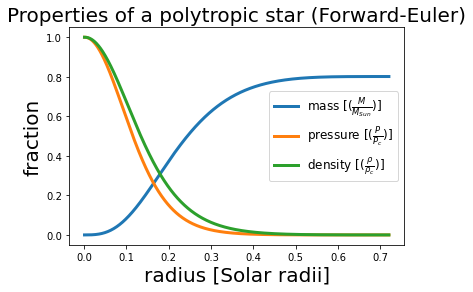

In [2]:
p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
dr = 0.001*6.96e8 #Solar radii
K = p0/((rho0)**exponent)

rmaxE,nrE = integrate_test(p0,dr,K,True) #Euler method
rE,vE = integrate_final(p0,dr,nrE,K,True)
pE = plot_profile(rE,vE,rho0,p0,K,True)

totalME = max(vE[...,0])/2e30 #total mass of star, Euler

**Cool, huh?** One thing you should immediately notice however is that this fake star (which I initialized with ~ solar parameters) only ends up with about 80% of the mass of the Sun, so our sim is clearly not perfect. 

### Exercise 0: understand it! 
Python indexing starts at zero so why shouldn't we? Add some comments to this code to make sure you understand what it's doing. If there's a line you don't understand, make a note of it in a comment and ask me! Better yet, start trying out "similar" code in a separate cell to see if you can intuit the behavior you didn't understand.

### Exercise 1: mess around!
Change the parameters in the cell above, and also try changing the polytropic index $n$ in the first cell. Note that it's probably best to only change one thing at a time, and you might want to make a note of what the default parameters are in case you go too far off the beaten path. See if you can get the plot to better match what the Sun should be and discuss your parameter choices with your group. My plot is pretty rudimentary, so you could also spice it up a bit if you like. That's what I always do to prevent myself from having to work on harder things.

### Exercise 2: break it! 
Focus your efforts on a single parameter now -- the stepsize $dr$. What do you notice happens to the solution as you change this parameter? Can you break the simulation? Why? Discuss.

### Exercise 3: improve it!
There are many problems with this simple code -- but there are two easy improvements we can make that should enhance its functionality.

#### 1: we should improve the accuracy...

Forward-Euler is the literal simplest of iterative schemes, and quite frankly it is terrible. The error ~ scales with the step size, which means we have to take *a lot* of steps to make this accurate (which is both computationally expensive and sometimes a bad idea precision-wise). An improvement on forward-Euler are the Runge-Kutta family of integrators. Below is some psuedo-code for a [4th-order Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) scheme integrating an imaginary differential equation $\frac{\mathrm{d}x}{\mathrm{dt}}=f(x,t)$:

```python 
v = [x0, vx0] #initial conditions, vx0 is dx/dt(0)
for i in range(start,stop):
    x = v[0] #position at each timestep
    vel = v[1] #velocity at each time step
    k1 = stepSize*f(x,t) #first constant
    k2 = stepSize*f(x+0.5*k1,t+0.5*stepSize) #second
    k3 = stepSize*f(x+0.5*k2,t+0.5*stepSize) #third
    k4 = stepSize*f(x+k3,t+stepSize) #4th
    v += (k1+2.0*k2+2.0*k3+k4)/6 #add weighted slope*timestep to solution
```

In this code the vector `v` gets evolved in time via our RK4 scheme, such that after the loop `v` will be equal to the solution at the final time. Note that if you wanted to keep track of what `v` is at *every* time step you would need to keep track of this in a separate array.

**Replace the `forward_euler_step` function in the large code cell above with an equivalent Runge-Kutta version, using the pseudo-code above as a basis.**

Once you've done this, compare your accuracy/stability with what it was before. Has it improved?

#### 2: we should improve the efficiency...

Did you notice that this scheme actually does the integration twice? The first time is a "test run" to find the endpoint for the integration. For loops are very computationally expensive (especially in Python), so this is not great. It doesn't have to be this way! **See if you can figure out a way to eliminate the need to find the endpoint in a separate loop such that the code only needs to integrate once.** 

#### 3: try other integrators!

Look up the documentation for the `odeint` function from `scipy.integrate`. See if you can replace your RK4 integrator above with this -- try integrators other than RK4 and see if you still get similar/sensible results.


### Optional for time/interest

Apply your work to some other ODEs that can't be solved by hand! Here is one idea:

1. The classic three-body problem. Consider three gravitational masses (stars, planets, moons, moon-sized space stations, etc) and evolve their positions in time using Newton's Law of Gravitation. [This one is near and dear to my heart](https://twitter.com/ThreeBodyBot). I am happy to provide a solution to this if you want!

## Exercise Two

What happens when we vary the dr parameter?

In [3]:
#make the exponent parametric

n=3.0 # polytropic index, n = 3 is special case where the enclosed mass M is solely determined by K
def get_exp(n=3.0):
    return  ((n+1)/n)

from scipy.constants import G # 6.6743e-11 m^3 kg^-1 s^-2


def gen_rho(P,K):
    """The equation of state gives density as a function of pressure.
    We assume a polytropic equation of state:
    P = K*rho^((n+1)/n)"""
    rho = np.abs(P/K)**(1/get_exp())
    return rho

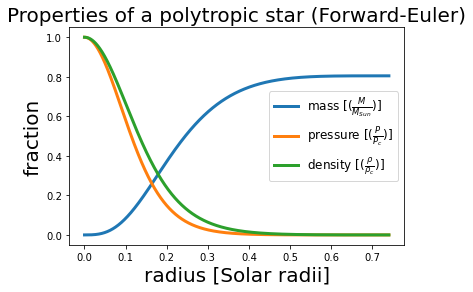

In [4]:
p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
dr = 0.0001*6.96e8 #Solar radii in meters
K = p0/((rho0)**get_exp(3))

rmaxE,nrE = integrate_test(p0,dr,K,True) #Euler method

#rE: vector of radii spaced dr apart
#vE 2d array, rows: rE, column[0] is mass, column[1] is pressure
rE,vE = integrate_final(p0,dr,nrE,K,True)
pE = plot_profile(rE,vE,rho0,p0,K,True)

totalME = max(vE[...,0])/2e30 #total mass of star, Euler

In [5]:
sims = {}
p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
r_sun = 6.96e8 #Solar radii in meters
#dr = 0.0001*6.96e8 #Solar radii in meters
K = p0/((rho0)**get_exp(3))
for dr in np.array([0.1, 0.01, 0.001, 0.0001, .00001])*r_sun:
    rmaxE,nrE = integrate_test(p0,dr,K,True) #Euler method

    #rE: vector of radii spaced dr apart
    #vE 2d array, rows: rE, column[0] is mass, column[1] is pressure
    rE,vE = integrate_final(p0,dr,nrE,K,True)

    sims[f'dr={dr:.2e} m']={'rE':rE, 'vE':vE}

In [6]:
def plot_mass(ax, sims, M_sun =1.989e30, R_sun = 6.96e8, meth='Forward-Euler' ):
    for s in sims:
        sim = sims[s]
        ax.plot(sim['rE']/R_sun, sim['vE'][:,0]/M_sun, label=s)
    
    ax.set_xlabel('Radius [Solar radii]',fontsize=20)
    ax.set_ylabel('Solar Fraction',fontsize=20)
    ax.set_title(f'Mass\n(Method: {meth})',fontsize=20)
    ax.legend()

def plot_pressure(ax, sims, P_0, R_sun = 6.96e8, meth='Forward-Euler' ):
    for s in sims:
        sim = sims[s]
        ax.plot(sim['rE']/R_sun, sim['vE'][:,1]/P_0, label=s)
    
    ax.set_xlabel('Radius [Solar radii]',fontsize=20)
    ax.set_ylabel('Solar Fraction',fontsize=20)
    ax.set_title(f'Pressure\n(Method: {meth})',fontsize=20)
    ax.legend()

def plot_density(ax, sims, rho_0, K, R_sun = 6.96e8, meth='Forward-Euler' ):
    for s in sims:
        sim = sims[s]
        pressure = sim['vE'][:,1]
        rho = gen_rho(pressure, K)
        ax.plot(sim['rE']/R_sun, rho/rho_0, label=s)
    
    ax.set_xlabel('Radius [Solar radii]',fontsize=20)
    ax.set_ylabel('Solar Fraction',fontsize=20)
    ax.set_title(f'Density\n(Method: {meth})',fontsize=20)
    ax.legend()

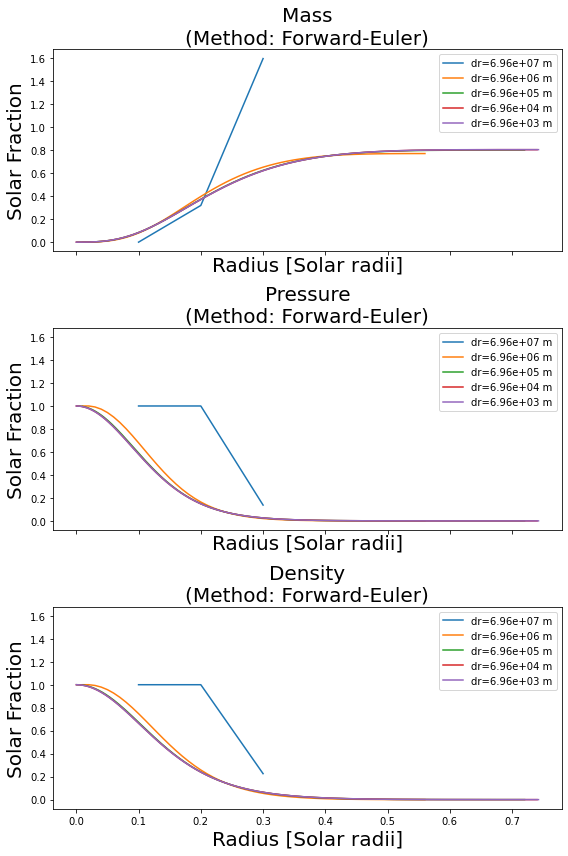

In [7]:
fig = plt.figure(figsize=(8,12))
axs = fig.subplots(3,1, sharex=True, sharey=True)
plot_mass(axs[0], sims)
plot_pressure(axs[1], sims, p0 )
plot_density(axs[2], sims, rho0, K)
fig.tight_layout()

The larger the $dr$ value, the less granular the calculations.  Looks like for small $dr$, the simulator will blow up.

In [8]:
sims = {}
p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
r_sun = 6.96e8 #Solar radii in meters
dr = 0.0001*6.96e8 #Solar radii in meters
K = p0/((rho0)**get_exp(3))
for n in np.array([1,2,3,4,5]):
    K = p0/((rho0)**get_exp(n))
    rmaxE,nrE = integrate_test(p0,dr,K,True) #Euler method

    #rE: vector of radii spaced dr apart
    #vE 2d array, rows: rE, column[0] is mass, column[1] is pressure
    rE,vE = integrate_final(p0,dr,nrE,K,True)

    sims[f'N={n}']={'rE':rE, 'vE':vE}

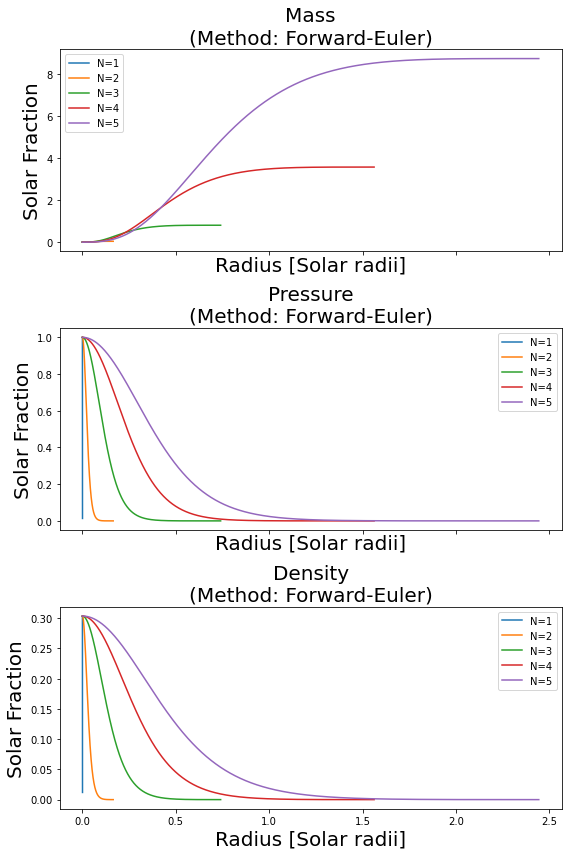

In [9]:
fig = plt.figure(figsize=(8,12))
axs = fig.subplots(3,1, sharex=True, sharey=False)
plot_mass(axs[0], sims)
plot_pressure(axs[1], sims, p0 )
plot_density(axs[2], sims, rho0, K)
fig.tight_layout()

### One Pass Implementation

In [10]:
def integrate_final_onepass(p0,dr,K,max_iter=10000, useEuler=True):
    """Once we know the final radius, we integrate to it
    and store our data."""
    M0 = 0
    r0 = dr
    P0 = p0
    v0 = np.array([M0,P0])
    r = np.arange(dr,(max_iter+1)*dr,dr)
    v = np.empty((max_iter,2),dtype=float)
    v[0] = v0
    for i in range(1,max_iter):
        #stop if pressure is 0
        if v[i-1,1] <= 0.0:
            i -= 1 #so that i is pointing to the end
            break
        if useEuler == False:
            v[i] = RK4_step(r[i-1],v[i-1],dr,K)
        else:
            v[i] = forward_euler_step(r[i-1],v[i-1],dr,K)

    success = 'Successful' if i < max_iter-1 else 'No success'
    return success, r[:i],v[:i]

In [11]:
for s in sims:
    n = len(sims[s]['rE'])
    print(f'Experiment: {s}, n iterations: {n}')

Experiment: N=1, n iterations: 7
Experiment: N=2, n iterations: 1651
Experiment: N=3, n iterations: 7401
Experiment: N=4, n iterations: 15615
Experiment: N=5, n iterations: 24429


In [12]:
sims_onepass = {}
p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
r_sun = 6.96e8 #Solar radii in meters
dr = 0.0001*6.96e8 #Solar radii in meters
for n in np.array([1,2,3,4,5]):
    K = p0/((rho0)**get_exp(n))
    #rE: vector of radii spaced dr apart
    #vE 2d array, rows: rE, column[0] is mass, column[1] is pressure
    success, rE,vE = integrate_final_onepass(p0,dr,K,useEuler=True)

    sims_onepass[f'N={n}']={'Success': success,'rE':rE, 'vE':vE}

In [13]:
for s in sims:
    succ = sims_onepass[s]['Success']
    n = len(sims_onepass[s]['rE'])
    print(f'Experiment: {s}, Result: {succ}, Iterations: {n}')

Experiment: N=1, Result: Successful, Iterations: 7
Experiment: N=2, Result: Successful, Iterations: 1651
Experiment: N=3, Result: Successful, Iterations: 7401
Experiment: N=4, Result: No success, Iterations: 9999
Experiment: N=5, Result: No success, Iterations: 9999


In [14]:
sims_onepass[s]['rE']

array([6.960000e+04, 1.392000e+05, 2.088000e+05, ..., 6.957912e+08,
       6.958608e+08, 6.959304e+08])

In [15]:
sims_onepass['N=1']['vE'][:10]

array([[0.00000000e+00, 2.65000000e+16],
       [2.46135622e+23, 2.65000000e+16],
       [1.23067811e+24, 2.30719444e+16],
       [3.22729952e+24, 1.62057819e+16],
       [5.95070646e+24, 8.43489209e+15],
       [8.55829896e+24, 2.81552848e+15],
       [1.02072680e+25, 3.50886378e+14]])

In [16]:
sims['N=1']['vE'][:10]

array([[0.00000000e+00, 2.65000000e+16],
       [2.46135622e+23, 2.65000000e+16],
       [1.23067811e+24, 2.30719444e+16],
       [3.22729952e+24, 1.62057819e+16],
       [5.95070646e+24, 8.43489209e+15],
       [8.55829896e+24, 2.81552848e+15],
       [1.02072680e+25, 3.50886378e+14]])

## Scipy Integrate solve_ivp

In [17]:
from scipy.integrate import solve_ivp

In [26]:

def gen_rho2(P,K, exponent):
    """The equation of state gives density as a function of pressure.
    We assume a polytropic equation of state:
    P = K*rho^((n+1)/n)"""
    rho = np.abs(P/K)**(1/exponent)
    return rho

def rhs2(r,v,K, exponent):
    """Right-hand side
    takes in vector v = [M,P]
    and returns [dM/dr,dP/dr]
    also requires radius r"""
    M,P = v
    rho = gen_rho2(P,K, exponent)
    dmdr = 4*np.pi*r**2*rho
    dpdr = -G*M*rho/(r**2)
    return np.array([dmdr,dpdr])


In [27]:
# Constants
n=3.0 # polytropic index, n = 3 is special case where the enclosed mass M is solely determined by K
exponent = ((n+1)/n)

p0 = 26.5e15 #Pascals, ~pressure at center of Sun
rho0 = 150e3 #kg/m^3, ~central density of Sun
dr = 0.001*6.96e8 #Solar radii
K = p0/((rho0)**exponent)
V_0 = np.array([0.0, p0])
t_eval = np.linspace(0, r_sun, 1000)
t_span = [0, r_sun]

sol = solve_ivp(rhs2, t_span,V_0, args=[K, exponent], t_eval=t_eval)


C:\Users\Owner\AppData\Local\Temp/ipykernel_19336/1459473383.py:16: RuntimeWarning: invalid value encountered in double_scalars
  dpdr = -G*M*rho/(r**2)


KeyboardInterrupt: 

In [21]:
sol.Y.shape

NameError: name 'sol' is not defined